In [89]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import sklearn.linear_model as skl
from sklearn.model_selection import train_test_split
import sklearn.model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.utils import resample

from numba import jit

In [90]:
def franke(x, y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

## Visualization of Franke Function

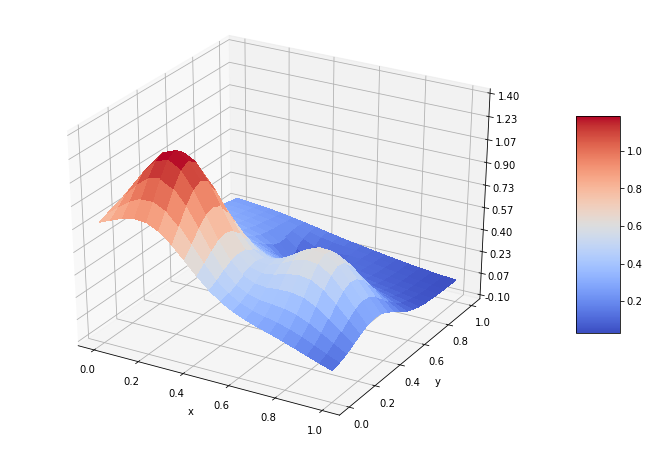

In [91]:
# Make data
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
x, y = np.meshgrid(x, y)

z = franke(x, y)

# Plot the surface
fig = plt.figure(figsize = (12, 8))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize the axes
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
plt.xlabel("x")
plt.ylabel("y")

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

## Setup of data

In [119]:
@jit
def designMatrix(x, y, order):
    n = x.size
    p = int((order + 1) * (order + 2) / 2) # number of columns in X. (from sum of numbers up to order + 1 formula). 21 for order = 5
    X = np.zeros((n, p))
    feature = 0
    for x_power in range(order + 1):
        for z_power in range(order - x_power + 1):
            X[:, feature] = x**x_power * y**z_power
            feature += 1
    return X

In [120]:
# Constants
n = 100 # datapoints
order = 5 # max order of polynomials

# Data
x = np.random.rand(n) #an array of 100 unordered uniform random numbers from 0 to 1
y = np.random.rand(n)

noise = np.random.randn(n) / 10
#x = np.linspace(0, 1, n)
#y = np.linspace(0, 1, n)
#x, y = np.meshgrid(x, y)
#x = np.ravel(x)
#y = np.ravel(y)
z = franke(x, y) + noise

# Design matrix, splitting and scaling
X = designMatrix(x, y, order)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)
scaler = StandardScaler() #subtracts mean from each feature and divides by the standard deviation
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_train[:, 0] = 1 # scaling removed the intercept terms
X_test = scaler.transform(X_test)
X_test[:, 0] = 1

## Regression methods

In [121]:
def OLS(X, y):
    beta = np.linalg.inv(X.T @ X) @ X.T @ y # beta = (X.T X)^-1 X.T y
    return beta

def ridge(X, y, lmda):
    beta = np.linalg.inv(X.T @ X + lmda * I) @ X.T @ y
    return beta

#beta = np.linalg.pinv(X_train) @ z_train # finds OLS for singular matrix using SVD and psuedoinverse

## Part a): Ordinary Least Square (OLS) on the Franke function 

In [122]:
beta = OLS(X_train, z_train)
z_mdl = X_test @ beta
print(mean_squared_error(z_mdl, z_test))

0.010573476026244196


## Part b)

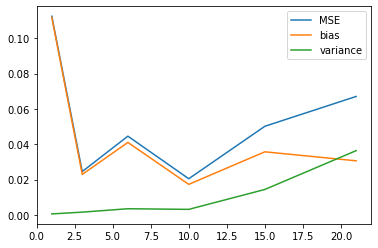

In [123]:
n_boostraps = 20
z_pred = np.empty((n_boostraps, z_test.size))
order = 5
p_arr = [(i + 1) * (i + 2) / 2 for i in range(order + 1)]
mse_arr = np.zeros(len(p_arr))
bias_arr = np.zeros(len(p_arr))
var_arr = np.zeros(len(p_arr))

for j in range(order+1):
    X = designMatrix(x, y, j)
    X_train, X_test, z_train, z_test = train_test_split(X, z, test_size = 0.2)
    scaler = StandardScaler() #subtracts mean from each feature and divides by the standard deviation
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_train[:, 0] = 1 # scaling removed the intercept terms
    X_test = scaler.transform(X_test)
    X_test[:, 0] = 1
    for i in range(n_boostraps):
        X_, z_ = resample(X_train, z_train)
        z_pred[i] = X_test @ OLS(X_, z_)

    mse_arr[j] = np.mean( np.mean((z_test - z_pred)**2, axis=0, keepdims=True) )
    bias_arr[j] = np.mean( (z_test - np.mean(z_pred, axis=0, keepdims=True))**2 )
    var_arr[j] = np.mean( np.var(z_pred, axis=0, keepdims=True) )
    #print(  (np.mean(   (z_test - z_pred)**2, axis=0, keepdims=True).shape))
    #print(z_test.shape)
    #print(z_pred.shape)
    #print((z_test - z_pred).shape)
    
plt.plot(p_arr, mse_arr, label='MSE')
plt.plot(p_arr, bias_arr, label='bias')
plt.plot(p_arr, var_arr, label='variance')
plt.legend()
plt.show()
#print(error)

## Part c)

Huske å begrunne hvorfor vi bruker/ikke bruker validation.

In [171]:
def split_index(data, k_folds):
    len_dataset = len(data) 
    fold = len_dataset//k_folds
    fold_index = []
    for k in range(k_folds-1):
        fold_index.append([k*fold,(k+1)*fold])
    fold_index.append((k_folds-1)*fold)
    return fold_index

def split(x, y, j):
    X = designMatrix(x, y, j)
    CV_list = []
    k_folds = 5
    fi = split_index(X,k_folds)
    for k in range(len(fi)-1):
        test_index = fi[k]
        X_test = np.zeros([test_index[1]-test_index[0],int(p_arr[j])])
        X_train = np.zeros([len(X)-len(X_test),int(p_arr[j])])
        X_train[:test_index[0]] = X[:test_index[0]]
        X_train[test_index[0]:] = X[test_index[1]:]
        X_test = X[test_index]
        
        z_test = np.zeros(test_index[1]-test_index[0])
        z_train = np.zeros(len(X)-len(z_test))
        
        z_train[:test_index[0]] = z[:test_index[0]]
        z_train[test_index[0]:] = z[test_index[1]:]
        z_test = z[test_index]
        CV_list.append([X_train,X_test,z_train,z_test])
    return CV_list
        
for j in range(order):
    for X_train, X_test, z_train, z_test in split(x, y, j):
    
    
    


(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
(20,) (80,) (100,)
